In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

# Ingesting the csv dataset
df = pd.read_csv('https://github.com/nataliea30/DiabetesML/blob/34862282fc8283b4ff686564763586c3a63bdcdd/diabetes_prediction_dataset.csv?raw=true')



In [5]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Counting the number of distinct values in each column
num_distinct_values = df.nunique()
print(num_distinct_values)

# Checking null values
print(df.isnull().sum())

# Removing the 'Other' category from the 'gender' column
df = df[df['gender'] != 'Other']

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


### Organization the Data of smokers

The data we have on the smokers is made up of very vague words. 

This function does it's best to group some anwsers together

In [6]:
# Define a function to map the existing categories to new ones in order to reduce to 3 main categories of smoking
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df.loc[:, 'smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())


smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [39]:
data = df.copy()

### Convert the data to numerical values

This block converts the data to numerical values for easiler processing in the machine learning algorithms. 
Machine learning algorithms work best with numerical values.

In [40]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

The correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used as a way to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

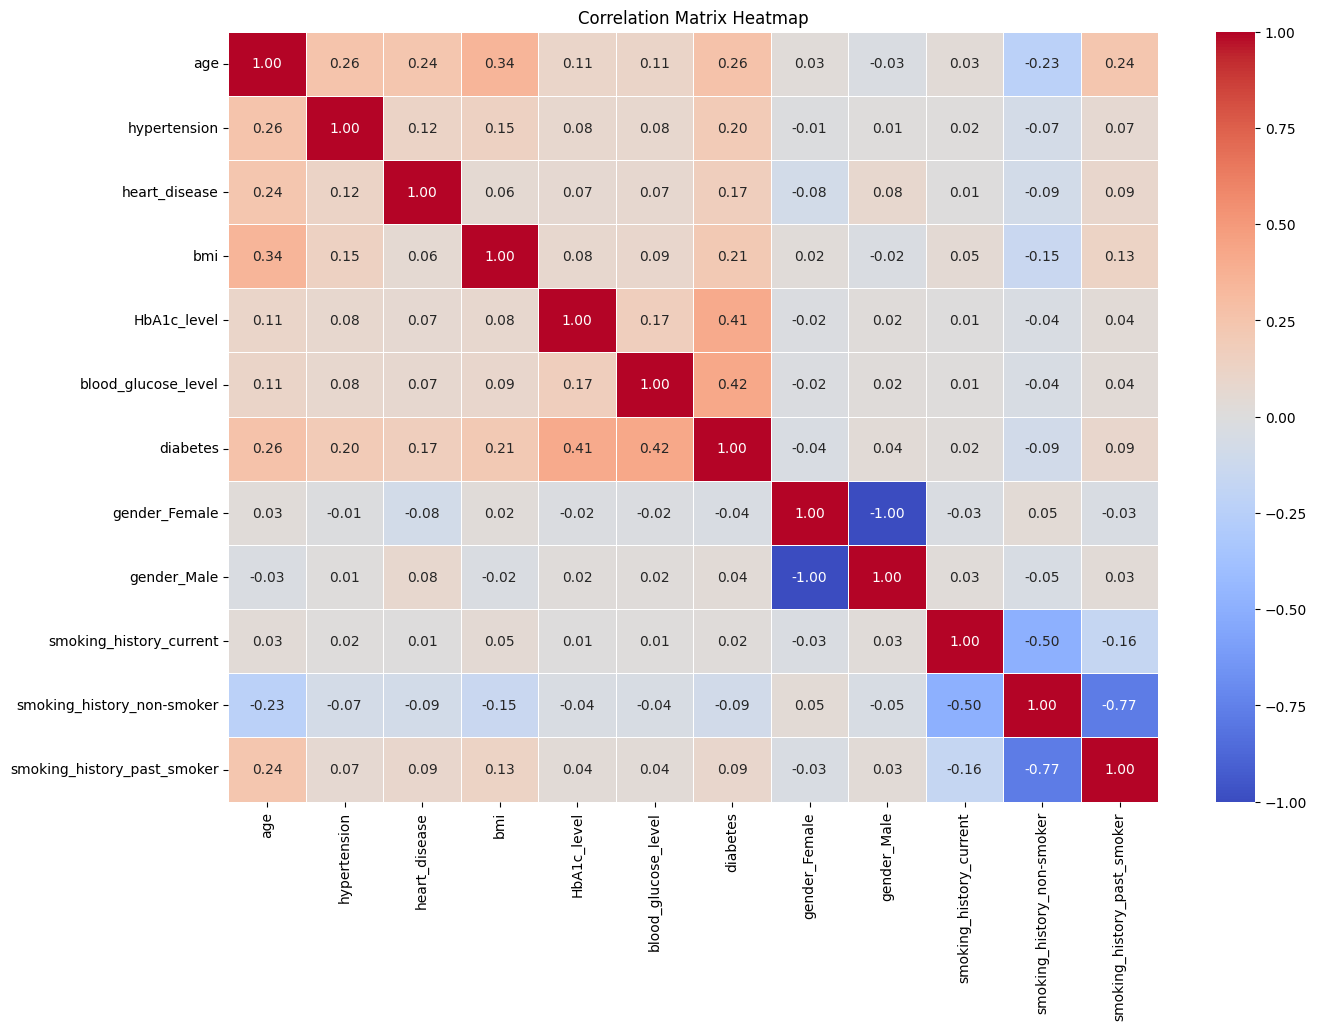

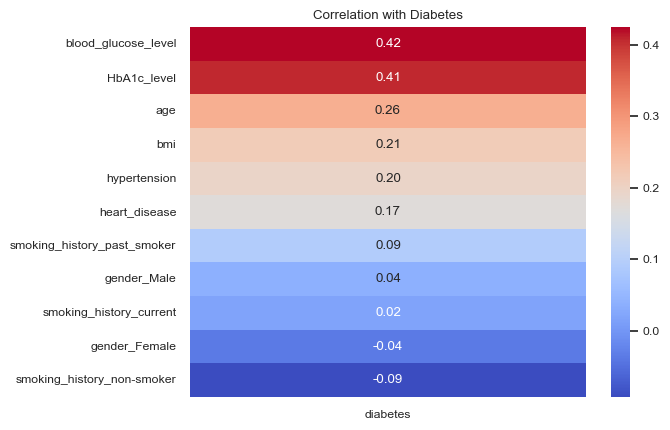

In [10]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

As you can see here, the majority of the people represented in this data set are non-diabetic. So we will have to be careful when training our model to not overfit the data.

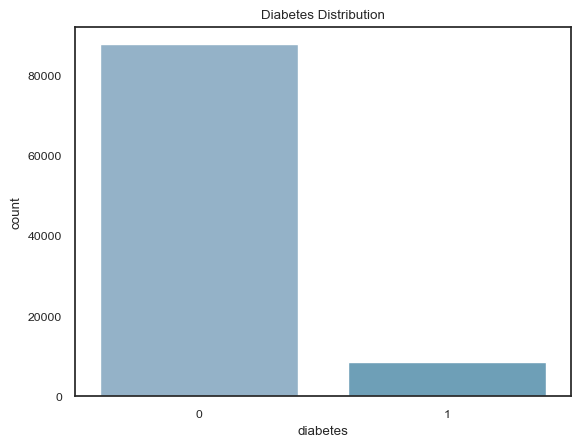

In [11]:
#data is unbalanced, 91% negative to 9% positive
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [41]:
data = data.drop('HbA1c_level', axis=1)
data = data.drop('blood_glucose_level', axis=1)
print(data.head())


    age  hypertension  heart_disease    bmi  diabetes  gender_Female  \
0  80.0             0              1  25.19         0           True   
1  54.0             0              0  27.32         0           True   
2  28.0             0              0  27.32         0          False   
3  36.0             0              0  23.45         0           True   
4  76.0             1              1  20.14         0          False   

   gender_Male  smoking_history_current  smoking_history_non-smoker  \
0        False                    False                        True   
1        False                    False                        True   
2         True                    False                        True   
3        False                     True                       False   
4         True                     True                       False   

   smoking_history_past_smoker  
0                        False  
1                        False  
2                        False  
3       

In [46]:

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','bmi']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])


# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()




# Split data into features and target variable
X = data.drop('diabetes', axis=1)
print(X.head())
y = data['diabetes']



# Preprocess the data, oversample, and undersample
X_preprocessed = X
#print(X_preprocessed[0])
X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)
#print(X_resampled[0])
# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)

import _pickle as cPickle

with open('Diabetes.model', 'wb') as f:
    cPickle.dump(clf, f)
    
print("Model saved")
print(X_preprocessed)


    age  hypertension  heart_disease    bmi  gender_Female  gender_Male  \
0  80.0             0              1  25.19           True        False   
1  54.0             0              0  27.32           True        False   
2  28.0             0              0  27.32          False         True   
3  36.0             0              0  23.45           True        False   
4  76.0             1              1  20.14          False         True   

   smoking_history_current  smoking_history_non-smoker  \
0                    False                        True   
1                    False                        True   
2                    False                        True   
3                     True                       False   
4                     True                       False   

   smoking_history_past_smoker  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
Mo

[1.45857031 1.51824451 1.         0.         0.         1.
 1.         0.         1.         0.         0.         1.        ]
Model Accuracy:  0.7813685501583045
              precision    recall  f1-score   support

           0       0.83      0.71      0.76     17530
           1       0.75      0.85      0.80     17529

    accuracy                           0.78     35059
   macro avg       0.79      0.78      0.78     35059
weighted avg       0.79      0.78      0.78     35059



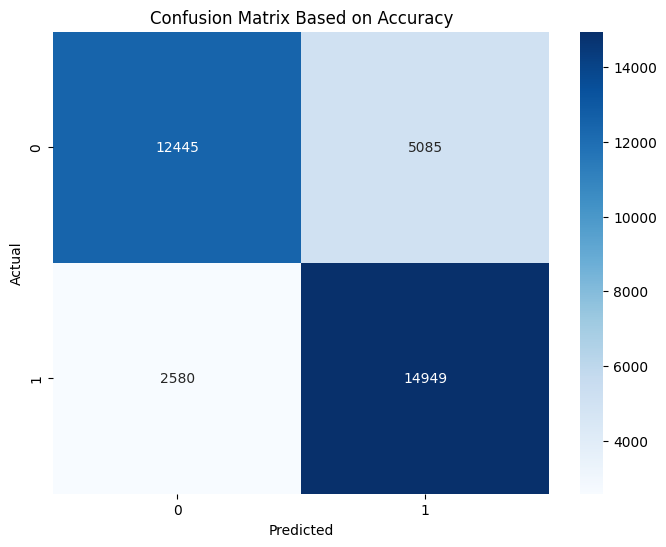

[-8.36773355e-01 -2.14288114e-04  1.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]


In [30]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)
print(X_test[0])

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(X_train[0])

The following is another Random Decision Classification Model optimized based on recall.


In [15]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])

# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()

# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)



ValueError: A given column is not a column of the dataframe

In [20]:
import _pickle as cPickle

with open('Diabetes.model', 'wb') as f:
    cPickle.dump(clf, f)

Model Recall Score:  0.8528153345883964
              precision    recall  f1-score   support

           0       0.83      0.71      0.76     17530
           1       0.75      0.85      0.80     17529

    accuracy                           0.78     35059
   macro avg       0.79      0.78      0.78     35059
weighted avg       0.79      0.78      0.78     35059



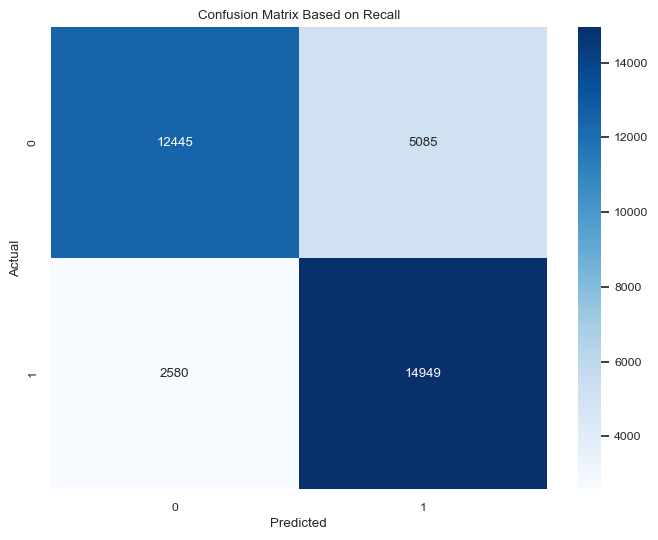

In [21]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)

# Evaluate the model
print("Model Recall Score: ", recall_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Recall')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

[[ 1.70070880e+00 -3.14941043e-01  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 5.43260798e-01 -2.14288114e-04  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-6.14187201e-01 -2.14288114e-04  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [ 1.43360541e+00  1.20333384e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-2.48581749e-01  1.01624415e+00  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 2.31640183e-01  2.33881132e+00  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]]


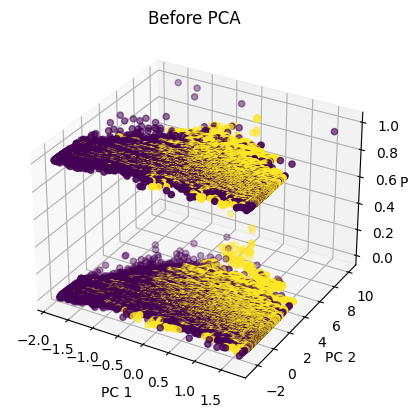

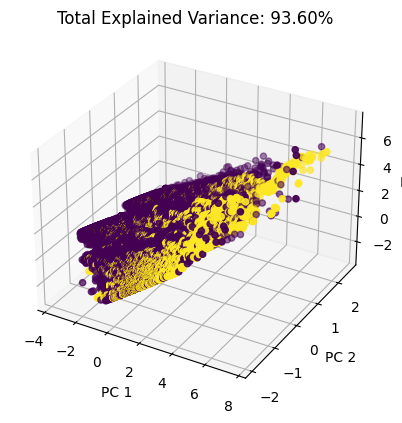

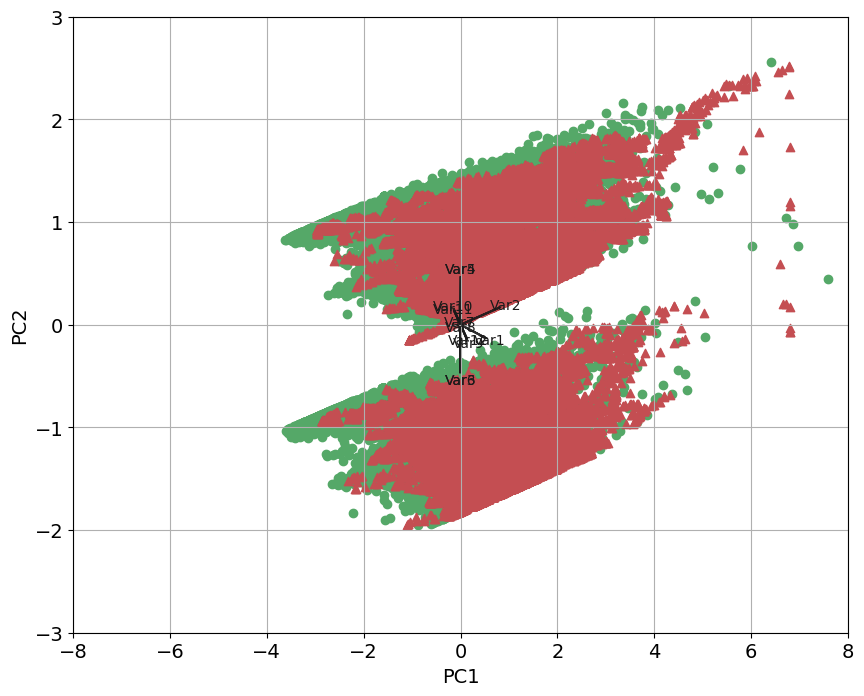

In [24]:

from sklearn.decomposition import PCA


X2 = X_resampled

print(X2)

# Get the principal components
pc1 = X2[:, 0]
pc2 = X2[:, 1]
pc3 = X2[:, 2]

# Create a scatter plot in 3D
fig = plt.figure()
ab = fig.add_subplot(111, projection='3d')
ab.scatter(pc1, pc2, pc3, c=y_resampled)

# Set the axis labels
ab.set_xlabel('PC 1')
ab.set_ylabel('PC 2')
ab.set_zlabel('PC 3')

ab.set_title(f'Before PCA')

plt.show()

# Perform PCA on the feature data
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X2)

# Get the principal components
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]
pc3 = X_pca[:, 2]

# Create a scatter plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc1, pc2, pc3, c=y_resampled)

# Set the axis labels
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Set the title
total_var = sum(pca.explained_variance_ratio_) * 100
ax.set_title(f'Total Explained Variance: {total_var:.2f}%')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_pca[:,0:14], np.transpose(pca.components_[0:14, :]), y_resampled)

# Show the plot
plt.show()

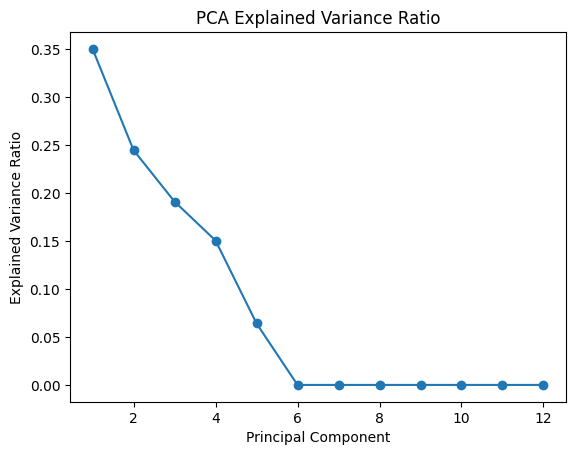

In [25]:
# Zero-center the scaled feature data
X_zero_centered = X2 - X2.mean(axis=0)

# Perform PCA on the zero-centered feature data
pca = PCA()
X_pca = pca.fit_transform(X_zero_centered)

# Calculate the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_

# Create a line plot for the explained variance ratio
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')

# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')

# Display the plot
plt.show()

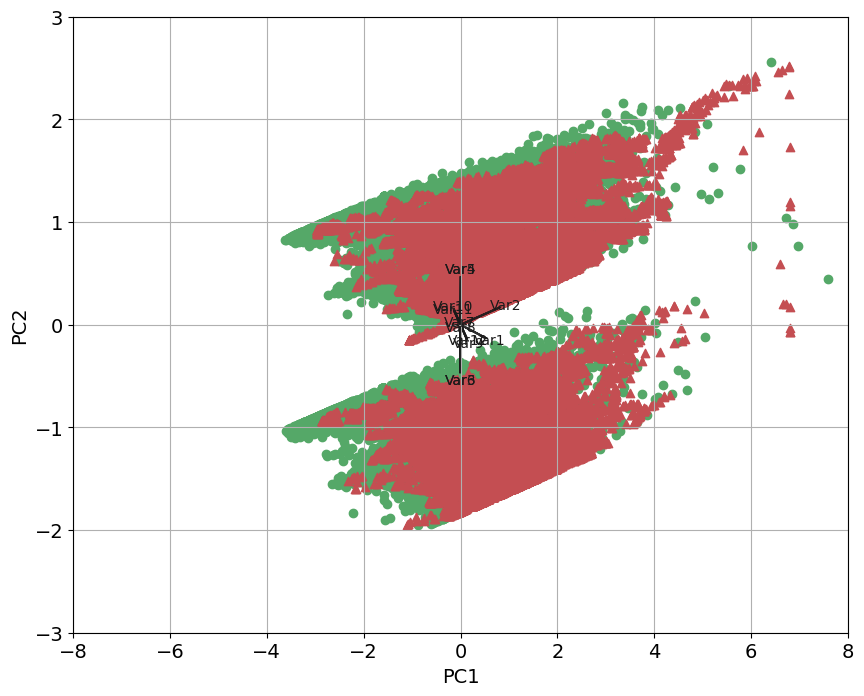

In [26]:
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)
    
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_pca[:,0:14], np.transpose(pca.components_[0:14, :]), y_resampled)
plt.show()

In [27]:
print(abs( pca.components_ ))


[[5.23083740e-01 8.08045047e-01 5.54332217e-03 5.54332217e-03
  5.54332217e-03 5.54332217e-03 1.15321658e-02 1.15321658e-02
  1.40788967e-01 1.40788967e-01 1.29256801e-01 1.29256801e-01]
 [1.30238219e-01 1.68003242e-01 4.66745224e-01 4.66745224e-01
  4.66745224e-01 4.66745224e-01 2.48895353e-02 2.48895353e-02
  1.55229599e-01 1.55229599e-01 1.30340064e-01 1.30340064e-01]
 [5.74307125e-01 5.46815009e-01 1.67688172e-01 1.67688172e-01
  1.67688172e-01 1.67688172e-01 2.01614937e-02 2.01614937e-02
  2.63787232e-01 2.63787232e-01 2.43625739e-01 2.43625739e-01]
 [6.13048467e-01 1.40304944e-01 6.30917843e-02 6.30917843e-02
  6.30917843e-02 6.30917843e-02 9.09725215e-02 9.09725215e-02
  4.20897971e-01 4.20897971e-01 3.29925449e-01 3.29925449e-01]
 [6.13539770e-02 1.20822771e-02 4.27445800e-03 4.27445800e-03
  4.27445800e-03 4.27445800e-03 5.69120697e-01 5.69120697e-01
  2.06583557e-01 2.06583557e-01 3.62537140e-01 3.62537140e-01]
 [1.17464434e-14 1.37921913e-16 1.95271188e-03 6.50169073e-04
  6

In [29]:
# Compute the correlation matrix
correlation_matrix = X_pca
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

KeyboardInterrupt: 

In [ ]:
testData = np.array([[0.24912661,-0.20087521 ,0,0,1,1,1,0]])

clf.predict(testData)



array([0])